# D213 Advanced Data Analysis Performance Assessment, Task # 1 Time Series Modeling

##### Submitted by Kimberly Hubacek Student ID: 001249836

## A1. Research Question


####Is it possible to forecast Telco Communication's revenue from August 2017 through December 2017 using time series analysis? 

## A2. Goal of Analysis

####The goal of this analysis is to create a forecast of Telco Communication’s daily revenues for a period from August 2017 through December 2017 using the provided data in the churn dataset. This will be done by converting the data into a time series object, splitting the data into training and test sets and running an ARIMA model on the training data. The training set will consist of the first 80% of the data, while the remaining 20% while comprise the test data set. An ARIMA  model will be run on the training set data to evaluate it and make predictions about the test data. The test data will be compared to the ARIMA predictions to assess the accuracy of the ARIMA model and the forecasted predictions. The resulting data will be evaluated to see if there is seasonality,  or other trends present that will allow Telco Communications’ management to forecast increases and dips in revenue for the upcoming fiscal year.

## B.  Assumptions of a Time Series Model

####Time series analysis using ARMA or ARIMA models makes the following assumptions of the data being analyzed:

1.	The data is stationary: This means the data contains no trends or seasonality. Trends are a steady increase or decrease in the values the data contains. Seasonality is a predictable increase or decrease in the values the data contains that occur over a specific period. Examples of this includes increases in retail sales around Christmas time. 
2.	The data lacks outliers or other anomalous data. This will be checked during the data cleaning and preparation stage.
3.	The data is univariate. The analysis seeks to model a single variable. For this analysis, that variable is Revenue. 
4.	  Past datapoints in the data are indicative of the behavior of future datapoints (Rink, 2022).

Since the data provided does not contain a start date nor end date, I cannot guarantee the predictions made by the ARIMA models will correspond with future revenues for Telco Communications. There could have been events that occurred during or immediately after the data was collected that could significantly effect the telecommunications market. The COVID-19 pandemic is an example of an event that considerably altered many markets and made future predictions unreliable. I am assuming the staff at WGU who have prepared this dataset for student use have taken this into consideration and the data provided will be able to be used to model future market behavior in an acceptable manner. 

In [3]:
# Loading Libraries and Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.metrics import mean_squared_error
# Check for stationarity
from statsmodels.tsa.stattools import adfuller
# Splitting the data into train and test sets
from sklearn.model_selection import train_test_split
# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
# Autocorrelation and Partial AUtocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# ARIMA
from statsmodels.tsa.arima.model import ARIMA
#Auto ARIMA
from pmdarima import auto_arima
#compare fuller to kpss
from statsmodels.tsa.stattools import kpss
# Predictions
from statsmodels.graphics.tsaplots import plot_predict

#import warnings filter for readability
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('telco_time_series.csv', index_col='Day', parse_dates=True)
df.head()

,Revenue
Day,
1,0.000000
2,0.000793
3,0.825542
4,0.320332
5,1.082554


In [5]:
df.tail()

,Revenue
Day,
727,16.931559
728,17.490666
729,16.803638
730,16.194813
731,16.620798


## Data exploration

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 1 to 731
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [7]:
df.describe()

,Revenue
count,731.000000
mean,9.822901
std,3.852645
min,0.000000
25%,6.872836
50%,10.785571
75%,12.566911
max,18.154769


In [8]:
print(df.shape)

(731, 1)


In [9]:
print(df)

       Revenue
Day           
1     0.000000
2     0.000793
3     0.825542
4     0.320332
5     1.082554
..         ...
727  16.931559
728  17.490666
729  16.803638
730  16.194813
731  16.620798

[731 rows x 1 columns]


array([[<AxesSubplot:title={'center':'Revenue'}>]], dtype=object)

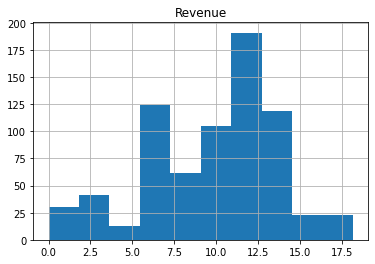

In [10]:
#view distribution of Revenue data
df.hist('Revenue')

## Data Preparation

In [11]:
# Checking data for null/Na values
df.isnull().any()

Revenue    False
dtype: bool

In [12]:
#Checking for Duplicate rows
df.duplicated().sum()

0

In [13]:
# changing Revenue Column to Pythonic name
df.columns=['revenue']

## Converting Dataframe into time series object

In [14]:
#change day to date, January 1st, 2016 will be used to accomodate for leap year
df.index = pd.date_range(start='2016-01-01', periods=731, freq='D')
df.head()

,revenue
2016-01-01,0.000000
2016-01-02,0.000793
2016-01-03,0.825542
2016-01-04,0.320332
2016-01-05,1.082554


array([[<AxesSubplot:title={'center':'revenue'}>]], dtype=object)

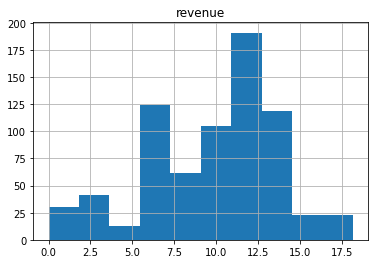

In [15]:
#view distribution of data
df.hist()

## C1.  Visualizing the Realization of the Time Series

####The provided dataset represents the two years of revenue from Telco Communications. There are two columns in the dataset. The first column ‘Day’ starts from January 1st, 2016 and goes through December 31st, 2017. The second column 'Revenue' is the daily revenue for that corresponding day, indicating the profits (or losses) Telco Communications had that day, in millions of USD. The graph below shows an upwards trend, indicating overall profit for Telco Communications from 2016 through 2017.

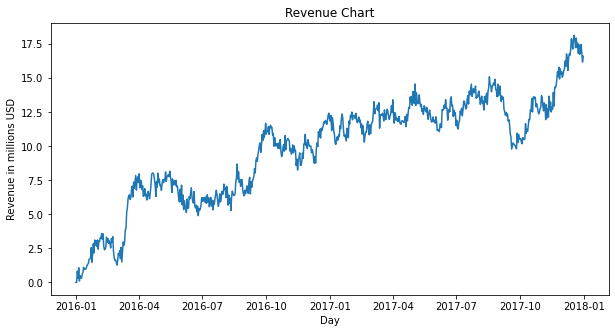

In [16]:
# C1. Provide a Linegraph visualizing the realization of the time series

plt.figure(figsize = (10,5))
plt.plot(df.revenue)
plt.title('Revenue Chart')
plt.xlabel('Day')
plt.ylabel('Revenue in millions USD')
plt.show()

## C2.  Description of the Time Step Formatting of the Realization

####The time series contains a DateTime index and the linking observation of Telco Communications revenue for that day in millions of dollars USD. The index increments by a single day for each observation. There are no gaps in measurement as each day has a recorded revenue. The length of the sequence is 731 datapoints, or days, long. This indicates the data was collected over a two-year period that contained a leap year.

## C3. Evaluate Stationarity of Time Series

####Data that is stationary contains no trends or seasonality (Brownlee, 2020). There is a visually observable upwards trend of the time series, with Telco’s revenue starting near zero on Day 1 and ending near $16 million on December 31st, 2017. This visible trend indicates the data is not stationary. 

There are other ways to determine stationarity if a trend is not visually observable. One way to determine stationarity is to run an Augmented Dicky-Fuller Test. An Augmented Dicky Fuller Test determines stationarity by performing a unit root test. If the time series can be represented by a unit root, that would indicate the time series is not stationary.  First, a null hypothesis and an alternative  hypothesis are formed. The null hypothesis is that the time series can be represented by a unit root. The alternative hypothesis is that the time series cannot be presented by a unit root and is therefore stationary. 

The test will return P-Values on the data. They are used to evaluate if there is a unit root. P-Values at or above a certain threshold, in this case 0.05, indicate the time series failed to reject the null hypothesis,  has a unit root, and is not stationary. P-Values below 0.05 indicate the time series rejected the null hypothesis, does not have a unit root, and is stationary (Brownlee, 2020). 


In [17]:
# Augmented Dicky Fuller Test to check for stationarity

X = df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.924612
p-value: 0.320573
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


####The results of the Augmented Dicky Fuller Test align with the visual observations of the time series line graph. The P-Value above 0.05 indicate the data is indeed not stationary. 

## C4. Data Preparation

####To prepare the data for analysis using ARIMA, the data was explored and checked for null values and duplicated columns. The “Day” column was converted to a suitable DateTime format and set as the index for the time series. The “Revenue” data was transformed to make it stationary, and finally the data was split into training and test datasets. 

First, the data was loaded into Jupyter notebook and explored. When loading the data, the “Day” column was set as the index and the dates were parsed. After the dataframe was loaded, “df.info”, “df.describe”, and “df.shape” functions were used to explore the data and retrieve statistical values such as the mean, medium, and standard deviation. One discovery during data exploration was the Revenue column had 731 rows with a mean value of 9.82. 
The data was then checked for null values using pandas “.isnull.any()” command. This returned no null or NaN values in the dataset. Following this, pandas duplicated.sum() command was used to check for duplicate rows. No duplicate rows were detected:

The data was then converted into Time Series format and the date was set as the index for the data. This assigned a calendar date for each day in the “Day” column. January 1st, 2016 was chosen as my start date since 2016 was a leap year. Starting on January 1st, 2020 would have been a more recent leap year, but the data provided in this project did not account for the volatile market changes in 2020 and 2021 brought on by COVID-19 pandemic and lockdowns. 
With the “Day” column converted to DateTime format and set as the index, a visualization of the data was created to satisfy C1 of the rubric. 
Following this, the Revenue data was coerced into stationarity by differencing it using the “.diff” function.  This computes the difference of each successive datapoint by subtracting the previous observation from the current observation. This helped stabilize the mean of the time series and reduced or potentially removed any trends or seasonality. January 1st, 2016 turned into a null value since there was no previous data for the “.diff” function to take the difference of.  January 1st, 2016 was removed using “.dropna()”. This addressed the newly created null value and reduced the dataset from 731 values to 730 values. The date range of newly reduced values are January 2nd, 2016 – December 31st, 2017.  


## Making "revenue" Column Stationary Via Differencing & Checking For Stationarity

In [19]:
# df_trans will be the name of the transformed dataset
df_trans = df.diff().dropna()

ADF Statistic: -44.874527
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


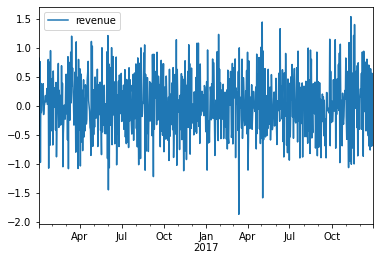

In [20]:
# Augmented Dickey-Fuller to test differenced data for stationarity
X = df_trans.revenue
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))
# Plot to verify stationarity
df_trans.plot();

####The stationarity of the differenced data was confirmed by running another Augmented Dickey-Fuller Test. Just as before in part C3 of this report, the P-Value level to reject the null hypothesis and determine stationarity is any P-Value below 0.05. The P-Value of the transformed data is 0.00. The plot of the transformed data also shows no visible trends, seasonality, or other signs of non-stationarity.

With the data stationary, both the original dataset and the differenced stationary dataset were then split into training and test datasets using SciKit-Learn's “train_test_split”. 80% of the data in each dataset went into the training dataset while the remaining 20% was placed into a test dataset. A total of 584 rows went to the training datasets while 146 rows went to the test datasets.  “shuffle = False” was set to ensure the data was not rearranged or taken out of order.

## Separating the Data in into Training and test data sets

In [55]:
# Splitting original data
train, test = train_test_split(df, test_size=0.2, shuffle=False, random_state=89)
# Viewing original data train dataset
print(train.head)
print(train.tail)

<bound method NDFrame.head of               revenue
2016-01-01   0.000000
2016-01-02   0.000793
2016-01-03   0.825542
2016-01-04   0.320332
2016-01-05   1.082554
...               ...
2017-08-02  13.938920
2017-08-03  14.052184
2017-08-04  13.520478
2017-08-05  13.082643
2017-08-06  13.504886

[584 rows x 1 columns]>
<bound method NDFrame.tail of               revenue
2016-01-01   0.000000
2016-01-02   0.000793
2016-01-03   0.825542
2016-01-04   0.320332
2016-01-05   1.082554
...               ...
2017-08-02  13.938920
2017-08-03  14.052184
2017-08-04  13.520478
2017-08-05  13.082643
2017-08-06  13.504886

[584 rows x 1 columns]>


In [56]:
# Viewing Test dataframe
print(test.head)
print(test.tail)

<bound method NDFrame.head of               revenue
2017-08-07  13.684826
2017-08-08  13.152903
2017-08-09  13.310290
2017-08-10  12.665601
2017-08-11  13.660658
...               ...
2017-12-27  16.931559
2017-12-28  17.490666
2017-12-29  16.803638
2017-12-30  16.194813
2017-12-31  16.620798

[147 rows x 1 columns]>
<bound method NDFrame.tail of               revenue
2017-08-07  13.684826
2017-08-08  13.152903
2017-08-09  13.310290
2017-08-10  12.665601
2017-08-11  13.660658
...               ...
2017-12-27  16.931559
2017-12-28  17.490666
2017-12-29  16.803638
2017-12-30  16.194813
2017-12-31  16.620798

[147 rows x 1 columns]>


In [57]:
# Splitting differenced data
DFtrain, DFtest = train_test_split(df_trans, test_size=0.2, shuffle=False, random_state=89)
# Viewing differenced train dataset
print(DFtrain.head)
print(DFtrain.tail)

<bound method NDFrame.head of              revenue
2016-01-02  0.000793
2016-01-03  0.824749
2016-01-04 -0.505210
2016-01-05  0.762222
2016-01-06 -0.974900
...              ...
2017-08-03  0.113264
2017-08-04 -0.531705
2017-08-05 -0.437835
2017-08-06  0.422243
2017-08-07  0.179940

[584 rows x 1 columns]>
<bound method NDFrame.tail of              revenue
2016-01-02  0.000793
2016-01-03  0.824749
2016-01-04 -0.505210
2016-01-05  0.762222
2016-01-06 -0.974900
...              ...
2017-08-03  0.113264
2017-08-04 -0.531705
2017-08-05 -0.437835
2017-08-06  0.422243
2017-08-07  0.179940

[584 rows x 1 columns]>


In [58]:
# Viewing differenced Test dataframe
print(DFtest.head)
print(DFtest.tail)

<bound method NDFrame.head of              revenue
2017-08-08 -0.531923
2017-08-09  0.157387
2017-08-10 -0.644689
2017-08-11  0.995057
2017-08-12 -0.438775
...              ...
2017-12-27  0.170280
2017-12-28  0.559108
2017-12-29 -0.687028
2017-12-30 -0.608824
2017-12-31  0.425985

[146 rows x 1 columns]>
<bound method NDFrame.tail of              revenue
2017-08-08 -0.531923
2017-08-09  0.157387
2017-08-10 -0.644689
2017-08-11  0.995057
2017-08-12 -0.438775
...              ...
2017-12-27  0.170280
2017-12-28  0.559108
2017-12-29 -0.687028
2017-12-30 -0.608824
2017-12-31  0.425985

[146 rows x 1 columns]>


##C5.  Copy of the Cleaned Data Set

####Please see the D213Task1cleanData.csv file included with my submission for a copy of the cleaned dataset. I have also included copies of the original data training dataset (D213Task1_train.csv) and the test dataset (D213Task1_test.csv).

In [59]:
# Exporting Prepared Data to CSV
df_trans.to_csv('D213Task1cleanTransformedData.csv', index = True)

In [60]:
# Exporting Train and Test Datasets to CSV
train.to_csv('D213Task1_train.csv')
# Save dataframe to CSV
test.to_csv('D213Task1_test.csv')

In [61]:
# Exporting the differenced train and test datasets to CSV
DFtrain.to_csv('D213Task1_differenced_train.csv')
# Save dataframe to CSV
DFtest.to_csv('D213Task1_differenced_test.csv')

##D1. Report of Findings 

####Visualizations were created of the data after differencing and decomposing it to check for seasonally, trends, residuals, and the spectral density of the data. Please see the visualizations and key findings below:

### Decomposed Time Series

####Below are the combined graphs of the decomposed time series. The decomposed time series includes a line graph of the differenced and decomposed Revenue data, the trend of the differenced and decomposed data, the Seasonality of the differenced and decomposed data, and the residuals of the differenced and decomposed data.

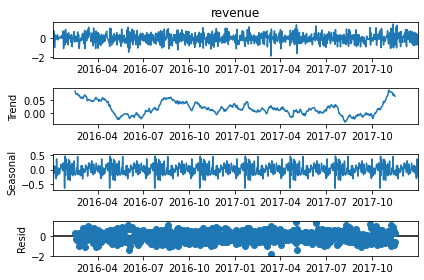

In [26]:
# Decompose Time Series
decomp = seasonal_decompose(df_trans['revenue'],  
                            period = 90) 
# plot decomposition  
decomp.plot() 

plt.show()

### Seasonality

####Below are two graphs visualizing the seasonality of the differenced data. The x-Axis represents the time frame of the graph, which is January 1st, 2016, through December 31st 2017 for the first graph. The y-axis represents the data’ distance from zero. There is a consistent pattern in the data after differencing and decomposition. This pattern appears to repeat every three months, which indicates some seasonality is still present. The seasonality magnitude ranges from 0.5 to -0.6, which is not a large amount. 

<AxesSubplot:title={'center':'Seasonality'}>

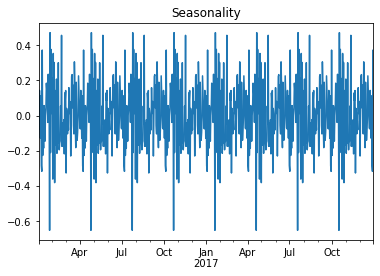

In [27]:
# Plotting Seasonality

plt.title('Seasonality')
decomp.seasonal.plot()

####A second graph was created spanning from January 1st, 2016, to July 1st, 2016 to confirm the presence of a quarterly season. A red line was placed on the first of every month. This graph clearly visualizes the three month or quarterly season, with a large dip occurring at the end of January and subsequent spike a few days later. This pattern repeats every three months with the next dip and spike occurring at the end of April 2016. This pattern might coincide with the start or end of annual business quarters. Filing financial reports at the start or end of a quarter could explain the dips and spikes in revenue. The Augmented Dickey-Fuller Test confirmed the data is stationary, so the seasonality present is slight and may be addressed by choosing the correct ARIMA model.

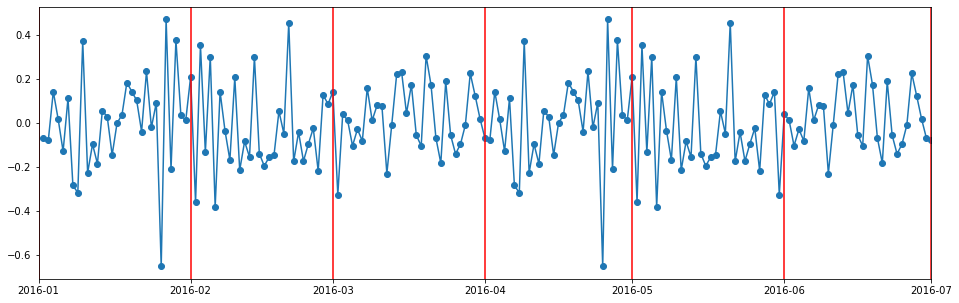

In [28]:
# Confirming Quarterly season with 7 month seasonal graph
plt.figure(figsize = [16,5])
plt.plot(decomp.seasonal, marker='o')
plt.xlim(pd.to_datetime('2016-01-01'), pd.to_datetime('2016-07-01'))
# Draw red lines on the first of the month
plt.axvline(x=pd.to_datetime('2016-01-01'), color='red')
plt.axvline(x=pd.to_datetime('2016-02-01'), color='red')
plt.axvline(x=pd.to_datetime('2016-03-01'), color='red')
plt.axvline(x=pd.to_datetime('2016-04-01'), color='red')
plt.axvline(x=pd.to_datetime('2016-05-01'), color='red')
plt.axvline(x=pd.to_datetime('2016-06-01'), color='red')
plt.axvline(x=pd.to_datetime('2016-07-01'), color='red');

### Autocorrelation Functions

####Autocorrelation demonstrates how the data is correlating during certain time periods. The x-axis of the ACF and PCF represents periods of time during the data collection numbered 0 -10. The y-axis values indicate if the data is positively correlated (values between zero and one) or not correlated (negative values below zero). Zero values indicate the data is stationary. Any blue dots within the shaded blue area represent findings that are not statistically significant. Seeing as most of the values are near zero, it can be concluded that the differenced data is stationary and not correlated. 
The autocorrelation efficient can also be used to prove or disprove autocorrelation. An autocorrelation coefficient less than 0.5 indicates the data are not autocorrelated while autocorrelation coefficient above 0.5 demonstrate autocorrelation. The autocorrelation coefficient of the differenced data was calculated at -0.49, indicating no autocorrelation is present. Comparing the autocorrelation coefficient of the non-differenced data at 0.99 demonstrates that autocorrelation was removed from the data during differencing. 
The ACF and PACF visuals can be used to determining if the data is suited to an AR (autoregression) or MA (moving average) model. Looking at the statistically significant results outside of the blue shaded area. The ACF tails off at point two and the PCF becomes stationary at point one. An ACF that tails off in the beginning of the visual combined with a PCF that abruptly cuts off at point one indicates an autoregressive AR(1) model is suitable for the data (Fulton, n.d.). 


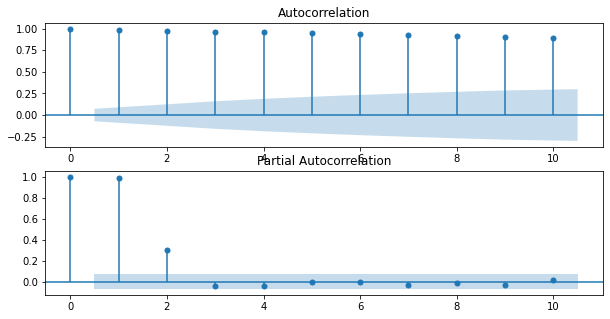

In [29]:
# Plotting Autocorrelation Functions

#ACF and PACF plots for non-differenced data
fig, ax = plt.subplots(2,1, figsize=(10,5))
plot_acf(df, lags=10, ax=ax[0])
plot_pacf(df, lags=10, ax=ax[1])
plt.show()

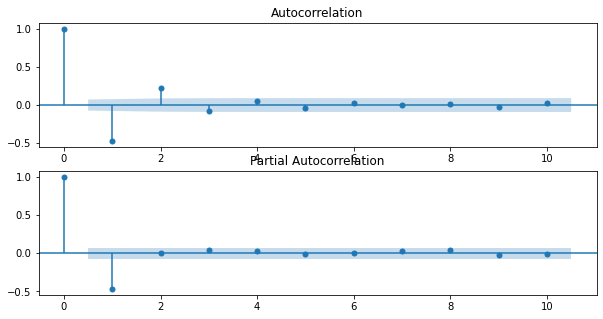

In [30]:
# Differenced Data ACF and PACF
fig, ax = plt.subplots(2,1, figsize=(10,5))
plot_acf(df_trans, lags=10, ax=ax[0])
plot_pacf(df_trans, lags=10, ax=ax[1])
plt.show()

In [31]:
# Calculating Autocorrelation Function
df_trans['revenue'].autocorr(), df['revenue'].autocorr()

(-0.4696890672062501, 0.9902917999411421)

### Spectral Density

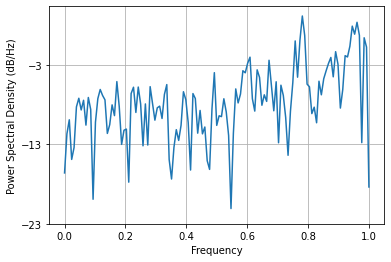

In [33]:
# Plotting Spectral Density
plt.psd(x=df_trans.revenue);

####Above is visual of the spectral density of the differenced data. The x-axis represents the frequency, or the number of observations that occur before a pattern in a time series repeats. The y-axis represents the power of the spectral density, or covariance between the previous and current time periods. Transforming the Power Spectral Density (y-axis) to the frequency (x-axis) creates the curve in the graph. 
Spectral density graphs can have signals or noise. Signals are observable patterns that would indicate seasonality in the data. Noise looks like random lines with no repeating patterns. Noise indicates the data is stationary. The spectral density looks like noise, with no discernable pattern  and confirms the differenced data is stationary.

### Trend

<AxesSubplot:title={'center':'Trend'}>

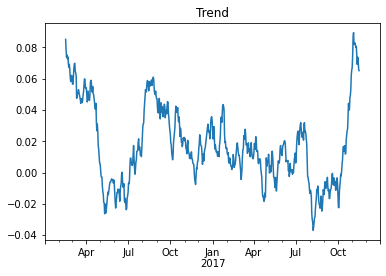

In [34]:
# Plotting Trend

plt.title('Trend')
decomp.trend.plot()

####The Trend graph visualizes any trends in the differenced data. The x-Axis represents the time frame of the graph, which is January 1st, 2016, through December 31st 2017. The y-axis represents the change in revenue in million USD. There are no visually discernable trends in the differenced and decomposed time series data. A trend would be indicated if the data had an overall direction, indication an overall increase or decrease in revenue. Telco Communications Revenue appears to both increase and decrease drastically during 2016 and 2017. 

### Residuals

<AxesSubplot:title={'center':'Residuals'}>

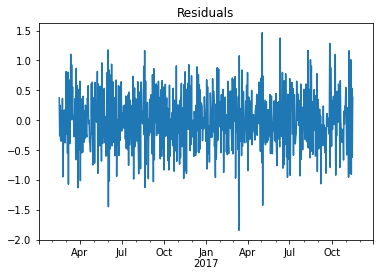

In [35]:
# Plotting Residuals
plt.title('Residuals')
decomp.resid.plot()

####The x-Axis represents the date of the residuals while the y-axis represents the distance from zero the residuals reside. The mean or average is around zero, indicating the data has been properly differenced. There are no visually discernable trends or autocorrelation in the residuals. 

## D2. ARIMA Model

####Based on the trends in the Autocorrelation plot, Partial Autocorrelation plot, and the presence of seasonality within the differenced and decomposed data, an AR(1) ARIMA model appears to be the best fit for the data. PMDArima Python library’s Auto-ARIMA was used to confirm AR(1) as the best model for the data. Auto-Arima performs a grid search to determine the optimal number of lag observations (p), integration (d), and moving average (q) for the ARIMA model. The model is then fit to the data based on the above parameters and a summary is printed with the stepwise search results. Auto-ARIMA evaluates a potential model’s fitness using AIC scores. The result with the lowest AIC scores identifies the best fitting model. Running auto-ARIMA on the non-differenced data confirmed an AR(1) model was the best choice.

## Running AutoARIMA to Determine Best Model and Fit

In [36]:
# AutoARIMA on original df.revenue data NOT DIFFERENCED DATA!
stepwise_fit=auto_arima(df['revenue'], trace=True, supress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=987.305, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1162.819, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=983.122, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1019.369, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1162.139, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=985.104, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=985.106, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=986.045, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=984.710, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.315 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -488.561
Date:                Sun, 10 Mar 2024   AIC                            983.122
Time:                        19:22:31   BIC                            996.901
Sample:                             0   HQIC                           988.438
                                - 731                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0332      0.018      1.895      0.058      -0.001       0.068
ar.L1         -0.4692      0.033    -14.296      0.000      -0.534      -0.405
sigma2         0.2232      0.013     17.801      0.000       0.199       0.248
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.05
Prob(Q):                              0.96   Prob(JB):                         0.36
Heteroskedasticity (H):               1.02   Skew:                            -0.02
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
# Ideal p = 1
# Ideal d = 1
# Ideal q = 0
# ARIMA (1,1,0)(0,0,0) indicates no seasonality is present in data.

## ARIMA Models

In [43]:
# Creating ARIMA model



# Inputting (p, d, q) from AutoARIMA
order = (1, 1, 0) 

# Create the ARIMA model
model = ARIMA(train, order=order)

# Fit the ARIMA model
model = model.fit()

model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                revenue   No. Observations:                  584
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -385.018
Date:                Sun, 10 Mar 2024   AIC                            774.035
Time:                        19:22:38   BIC                            782.772
Sample:                    01-01-2016   HQIC                           777.441
                         - 08-06-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4578      0.036    -12.618      0.000      -0.529      -0.387
sigma2         0.2193      0.014     15.954      0.000       0.192       0.246
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.81
Prob(Q):                              0.91   Prob(JB):                         0.40
Heteroskedasticity (H):               0.97   Skew:                            -0.07
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
#AIC 774.035

####The ARIMA model with the metrics from Auto ARIMA has an AIC score of 774. Two alternative models were created to test the initial model. Each subsequent model will be compared to the original by their AIC scores. THe model with the lowest AIC score is the best model that will be used to create the forecast.

In [45]:
# Alternate ARIMA #1 to test initial model
# Inputting random (p, d, q)
order = (1, 2, 1) 

# Create the ARIMA model
Altmodel = ARIMA(train, order=order)

# Fit the ARIMA model
Altmodel = Altmodel.fit()

Altmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                revenue   No. Observations:                  584
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -386.928
Date:                Sun, 10 Mar 2024   AIC                            779.855
Time:                        19:22:39   BIC                            792.955
Sample:                    01-01-2016   HQIC                           784.962
                         - 08-06-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4596      0.037    -12.566      0.000      -0.531      -0.388
ma.L1         -0.9998      0.107     -9.355      0.000      -1.209      -0.790
sigma2         0.2185      0.026      8.439      0.000       0.168       0.269
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.88
Prob(Q):                              0.91   Prob(JB):                         0.39
Heteroskedasticity (H):               0.97   Skew:                            -0.07
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
# AIC is 779, higher than Auto ARIMA stats = worse model

In [47]:
# Alternate ARIMA #2 to check AIC
# Inputting random (p, d, q)
order = (2, 2, 2) 

# Create the ARIMA model
Alt2model = ARIMA(train, order=order)

# Fit the ARIMA model
Alt2model = Alt2model.fit()

Alt2model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                revenue   No. Observations:                  584
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -386.683
Date:                Sun, 10 Mar 2024   AIC                            783.367
Time:                        19:22:39   BIC                            805.199
Sample:                    01-01-2016   HQIC                           791.877
                         - 08-06-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1514      0.790     -1.458      0.145      -2.699       0.396
ar.L2         -0.3347      0.348     -0.961      0.336      -1.017       0.348
ma.L1         -0.3175      0.998     -0.318      0.750      -2.274       1.639
ma.L2         -0.6824      0.953     -0.716      0.474      -2.550       1.185
sigma2         0.2183      0.146      1.500      0.134      -0.067       0.504
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.00
Prob(Q):                              0.89   Prob(JB):                         0.37
Heteroskedasticity (H):               0.96   Skew:                            -0.08
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
#AIC is 783, higher than AutoARIMA stats = worse model

####Both of the alternate models had higher AIC scores (779, 783) than the initial model (774). The initial ARIMA model with the metrics chosen by AUto-ARIMA is the best model and will be used to create the forecast.

In [49]:
# Rerunning Best ARIMA model based on lowest AIC score, which was the initial ARIMA with Auto ARIMA pdq

# Inputting (p, d, q) from AutoARIMA
order = (1, 1, 0) 

# Create the ARIMA model
model = ARIMA(train, order=order)

# Fit the ARIMA model
model = model.fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                revenue   No. Observations:                  584
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -385.018
Date:                Sun, 10 Mar 2024   AIC                            774.035
Time:                        19:22:39   BIC                            782.772
Sample:                    01-01-2016   HQIC                           777.441
                         - 08-06-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4578      0.036    -12.618      0.000      -0.529      -0.387
sigma2         0.2193      0.014     15.954      0.000       0.192       0.246
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.81
Prob(Q):                              0.91   Prob(JB):                         0.40
Heteroskedasticity (H):               0.97   Skew:                            -0.07
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## D3. Forecast

####The train dataset was loading into the ARIMA model to train the model. After training the model on the training data, a forecast was created and compared to the test data to test the forecast accuracy.. The forecast spanned 145 days, from August 2017 through December 31st, 2017. The x-axis includes the date of each day of the test dataset and the y-axis represents the difference in revenue in millions USD for that day.  The blue line represents the actual values of the test data while the orange line represents the forecasted values created by the ARIMA model.

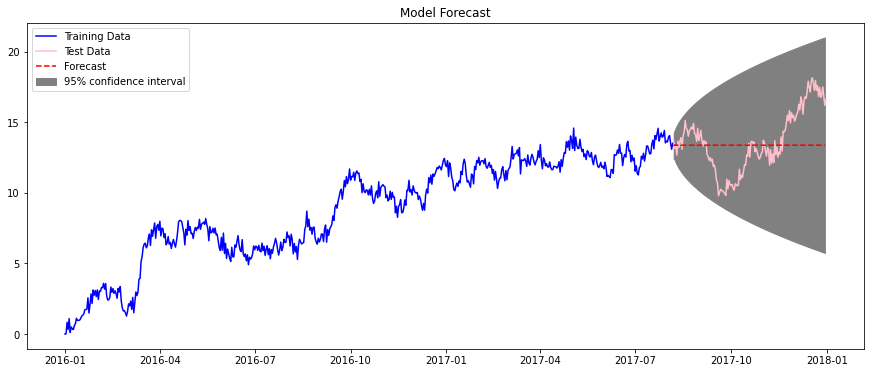

In [52]:
# Get forecast
forecast = model.get_forecast(steps=146, dynamic=True)

#calculate confidence interval
conf_int = forecast.conf_int()

# Plot the forecasts
plt.figure(figsize=(15,6))
plt.plot(train, color='blue', label='Training Data')
plt.plot(test, color='pink', label='Test Data')
plt.plot(forecast.predicted_mean, color='red', label='Forecast', linestyle='dashed')
plt.fill_between(conf_int.index, conf_int['lower revenue'], conf_int['upper revenue'], color = 'gray', label='95% confidence interval')
plt.plot()
plt.legend()
plt.title('Model Forecast')
plt.show()

####The ARIMA forecast predicts Telco Communications' revenue will remain steady at $13 million. This is no accurate to the test data.

## D4. Analysis Output and Calculations

In [53]:
#Predicted Mean
forecast.predicted_mean

2017-08-07    13.311586
2017-08-08    13.400077
2017-08-09    13.359566
2017-08-10    13.378112
2017-08-11    13.369622
                ...    
2017-12-26    13.372288
2017-12-27    13.372288
2017-12-28    13.372288
2017-12-29    13.372288
2017-12-30    13.372288
Freq: D, Name: predicted_mean, Length: 146, dtype: float64

In [63]:
#Confidence Intervals
forecast.conf_int()

,lower revenue,upper revenue
2017-08-07,12.393824,14.229347
2017-08-08,12.356091,14.444064
2017-08-09,12.108188,14.610945
2017-08-10,11.989503,14.766721
2017-08-11,11.839696,14.899548
...,...,...
2017-12-26,5.846715,20.897861
2017-12-27,5.820428,20.924148
2017-12-28,5.794232,20.950344
2017-12-29,5.768127,20.976449


In [62]:
# Calculating Root Mean Squared Error

# extracting the values from the dataframe
actual_values = df['revenue'].iloc[-146:].values 

# extracting the forecasted values
forecasted_values = forecast.predicted_mean.values

# calculate mse
rmse = mean_squared_error(actual_values, forecasted_values)

print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 4.768247711669446


####All other code and output is included within this Jupyter Notebook Report

##D5. Code of TIme Series Model

In [ ]:
####All fully executable code can be viewed above.

## E1. Results of Analysis

####As stated previously in part D1 of this report, the autocorrelation and partial autocorrelation functions were used to select the ARIMA model for this data. An ACF that tails off in the beginning of the visual combined with a PCF that abruptly cuts off at point one indicates an autoregressive AR(1) model is suited to the data.
This choice was confirmed by running Auto-ARIMA on the differenced data. The result with the lowest AIC score was the Autoregressive AR(1) model with predicted p,d,q values of (1,0,0).

The prediction interval of the forecast is 20% of the full dataset, or 146 steps. Each step represents a single 24-hour day.  It is common practice to place 20% - 30% of the total data into the test data set when splitting the data into test and training sets. 20% was chosen for this analysis due to the small size of the dataset compared to the long length of time requested to forecast. 

The forecast length of nearly five months is justifiable as that amounts to one and a half business quarters. This would allow Telco Communications to make business plans for the next quarter and be able to plan for the timeframe when the next quarters forecasts are generated. Comparing past forecasts to future forecasts also allows businesses to evaluate the accuracy of the forecasts produced. 

The root mean squared error (RMSE) was used as the error metric for this model. The lower the root mean square error, the better the model. The root mean sqaure error of the model was 4.768. While this is a low number, it would need to be compared to the RMSE of another model in order to assess which model contains less errors. 

In [65]:
# Calculating Root Mean Squared Error

# extracting the values from the dataframe
actual_values = df['revenue'].iloc[-146:].values 

# extracting the forecasted values
forecasted_values = forecast.predicted_mean.values

# calculate mse
rmse = mean_squared_error(actual_values, forecasted_values)

print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 4.768247711669446


####Diagnostic plots were used as the model's evaluation procedure. Diagnostic plots display visualizations for the standardized residual, a histogram with KDE estimates, a normal Q_Q plot, and a correlogram. The standard residual should have no pattern. The standardized residual plot meets this assumption. The histogram with KDE estimates should ideally show the KDE curve close to the distribution. THe model's histogram has a KDE curve that is close to the distribution. The Normal Q-Q plot should show all values within the red line. Witht he exception of a few points, all of the data points for this model align with the red line. Ideally all datapoints above zero should be within the shaded area of the correlogram. All the data points outside of zero are within the shaded area for the ARIMA model. Based on the diagnostic plots, the ARIMA model is statistically sound. 

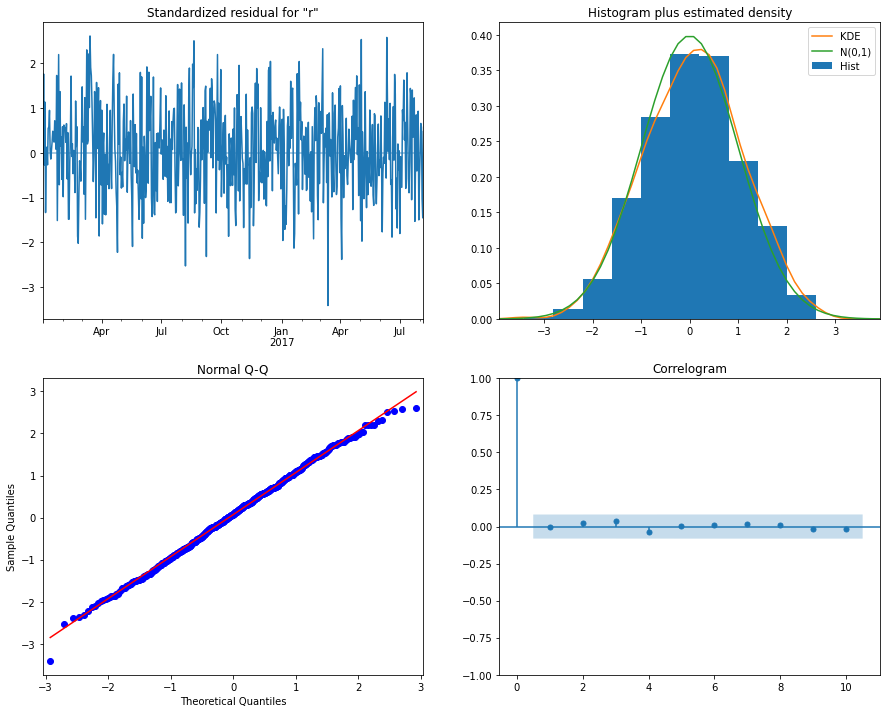

In [64]:
# Diagnostic Plots from original ARIMA model with AutoARIMA pdq
model.plot_diagnostics(figsize=(15, 12))
plt.show()

## E2 Visualization of Forecast

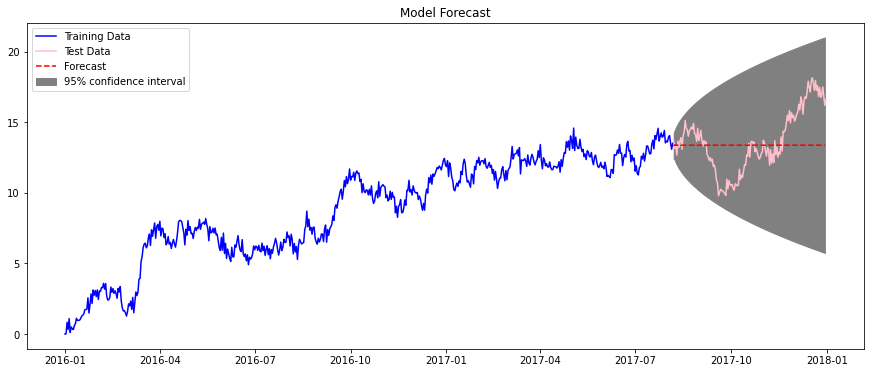

In [66]:
forecast = model.get_forecast(steps=146, dynamic=True)
#calculate confidence interval
conf_int = forecast.conf_int()
# Plot the forecasts
plt.figure(figsize=(15,6))
plt.plot(train, color='blue', label='Training Data')
plt.plot(test, color='pink', label='Test Data')
plt.plot(forecast.predicted_mean, color='red', label='Forecast', linestyle='dashed')
plt.fill_between(conf_int.index, conf_int['lower revenue'], conf_int['upper revenue'], color = 'gray', label='95% confidence interval')
plt.plot()
plt.legend()
plt.title('Model Forecast')
plt.show()

## E3. Recommendations

####Per my research question, I was able to create a forecast of Telco Communication's revenue from August 2017 through December 2017. While the forecast produced is statistically sound, it does not have much practical use due to the large confidence interval and it's inaccuracy compared to the values of the test data set. I would not recommend Telco Communications to make business decisions based on this forecast. I do believe it would be possible to create an accurate forecast of Telco Communication's revenue with a larger data sample. I recommend Telco Communications conduct further revenue analysis and study, ideally with a larger sample size of data spanning a minimum of three years. 

## F. Report

####This jupyter notebook with report has been submitted as a PDF document.

## G. Code Sources

####This article contained information about and code snippets for time series forecasting:
https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/

This article contained information on Stationarity and contained code to perform an Augmented Dicky Fuller Test:
https://machinelearningmastery.com/time-series-data-stationary-python/

Dr. Sewell of Western Governor’s University’s Presentation on ARIMA:
https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=358071e7-9c01-4274-a044-af7400ec1c40

Dr. Elleh of Western Governors University’s Presentation on Time Series Modeling:
https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=8d32afc8-d66f-42d5-9117-b100016cf9ac


## H. Academic Sources

####Brownlee, J. (2020, August 14). How to check if time series data is stationary with python. MachineLearningMastery.com. https://machinelearningmastery.com/time-series-data-stationary-python/ 

Fulton, J. (n.d.). DataCamp: ARIMA models in Python. ARIMA models in Python. DataCamp. Retrieved March 9, 2024, from https://www.datacamp.com/courses/arima-models-in-python. 

GeeksforGeeks. (2020, February 19). Python: Arima model for time series forecasting. GeeksforGeeks. https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/ 

Rink, K. (2022, July 27). Your comprehensive guide to the basics of Time Series Modeling. Medium. https://towardsdatascience.com/your-comprehensive-guide-to-the-basics-of-time-series-modeling-f673398b5df3 
